<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Import the packege

In [76]:
import shap
import logging
import warnings
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.multioutput import MultiOutputRegressor
from scipy.stats import wilcoxon, bootstrap
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer


warnings.filterwarnings('ignore')

## logging fit

In [77]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

## seed

In [78]:
SEED = 42  
np.random.seed(SEED)

# read data set

In [79]:
df_xlsx = pd.read_excel('../data/DummyData.xlsx')

df_xlsx.to_csv('../data/DummyData.csv', index=False)
logger.info("change the xlsx form csv file done! ")
df = pd.read_csv('../data/DummyData.csv')
df.shape
logger.info('read the csv file')
df_original = df.copy()
logger.info("copy data set done!")

2025-06-06 14:14:45,380 - INFO - change the xlsx form csv file done! 
2025-06-06 14:14:45,396 - INFO - read the csv file
2025-06-06 14:14:45,401 - INFO - copy data set done!


In [80]:
df.head()

,sex,age,educational_status,partner_status,employment_status,weight,height,BMI,treatment,EMI,...,nitrate,diuretic,psychotropic,angiotensin2_receptor_blocker,week,steps,mvpa_mins,perception,steps_goal,mvpa_mins_goal
0,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,72765,2105,16,95047.0,2509.0
1,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,53817,1557,2,74490.0,2063.0
2,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,58911,1704,4,70379.0,2163.0
3,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,85157,2463,8,125754.0,3164.0
4,2,34.0,3.0,0.0,2.0,48.0,164.0,17.85,0.0,0.0,...,0.0,0.0,0.0,0.0,5.0,51341,1485,12,68819.0,1886.0


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   sex                            566 non-null    int64  
 1   age                            564 non-null    float64
 2   educational_status             561 non-null    float64
 3   partner_status                 561 non-null    float64
 4   employment_status              561 non-null    float64
 5   weight                         561 non-null    float64
 6   height                         561 non-null    float64
 7   BMI                            561 non-null    float64
 8   treatment                      561 non-null    float64
 9   EMI                            559 non-null    float64
 10  EAP                            559 non-null    float64
 11  EPTCA                          559 non-null    float64
 12  ECABG                          559 non-null    flo

In [82]:
df.describe()

,sex,age,educational_status,partner_status,employment_status,weight,height,BMI,treatment,EMI,...,nitrate,diuretic,psychotropic,angiotensin2_receptor_blocker,week,steps,mvpa_mins,perception,steps_goal,mvpa_mins_goal
count,566.000000,564.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,561.000000,559.000000,...,561.000000,561.000000,561.000000,561.000000,561.000000,566.000000,566.000000,566.000000,531.000000,530.000000
mean,1.526502,48.753546,1.909091,0.520499,1.522282,77.306595,170.602496,26.537683,0.898396,0.157424,...,0.119430,0.160428,0.119430,0.155080,3.522282,42170.001767,1023.332155,5.328622,55226.549906,1260.035849
std,0.499739,14.723789,0.806628,0.500025,0.499949,15.792022,10.074398,4.984085,0.835815,0.364526,...,0.324583,0.367330,0.324583,0.362304,1.925381,22804.693283,624.349263,4.213101,30099.992532,773.527674
min,1.000000,25.000000,1.000000,0.000000,1.000000,46.000000,150.000000,17.170000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,2145.000000,5.000000,0.000000,3089.000000,6.000000
25%,1.000000,36.000000,1.000000,0.000000,1.000000,64.000000,164.000000,22.940000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,23264.000000,604.250000,2.000000,30682.500000,716.250000
50%,2.000000,47.000000,2.000000,1.000000,2.000000,78.000000,170.000000,26.300000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,42602.000000,961.000000,5.000000,54642.000000,1153.500000
75%,2.000000,62.000000,3.000000,1.000000,2.000000,90.000000,178.000000,29.970000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,5.000000,58830.250000,1400.750000,8.000000,77647.500000,1743.750000
max,2.000000,75.000000,3.000000,1.000000,2.000000,106.000000,190.000000,38.540000,2.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,8.000000,102990.000000,2745.000000,20.000000,143791.000000,3617.000000


In [83]:
df.columns

Index(['sex', 'age', 'educational_status', 'partner_status',
       'employment_status', 'weight', 'height', 'BMI', 'treatment', 'EMI',
       'EAP', 'EPTCA', 'ECABG', 'ECVA_TIA', 'riskfactor_familyhistory',
       'riskfactor_DM', 'riskfactor_hypertension', 'riskfactor_dyslipidemia',
       'riskfactor_smoking', 'acetylsalicylic_acid',
       'cholesterol_lowering_med', 'ACE_inhibitor', 'calcium_blocker',
       'beta_blocker', 'thienopyridine', 'oral_anticoagulant', 'nitrate',
       'diuretic', 'psychotropic', 'angiotensin2_receptor_blocker', 'week',
       'steps', 'mvpa_mins', 'perception', 'steps_goal', 'mvpa_mins_goal'],
      dtype='object')

In [84]:
df = df.dropna(subset=['steps_goal', 'mvpa_mins_goal'])
logger.info("Deleted rows with missing targets")
print(f"THis is the shape of data {df.shape}")

2025-06-06 14:14:46,260 - INFO - Deleted rows with missing targets


THis is the shape of data (525, 36)


In [85]:
df['weight_height_ratio'] = df['weight'] / df['height']
df['steps_week_interaction'] = df['steps'] * df['week']
logger.info("Added new features")

2025-06-06 14:14:46,373 - INFO - Added new features


In [86]:
# Drop the 'week' column
df = df.drop('week', axis=1)
logger.info("Dropped the week column")

2025-06-06 14:14:46,483 - INFO - Dropped the week column


# Split features and targets

In [87]:

X = df.drop(['steps_goal', 'mvpa_mins_goal'], axis=1)
y = df[['steps_goal', 'mvpa_mins_goal']]

# Split data into train, validation, and holdout

In [93]:
X_temp, X_holdout, y_temp, y_holdout = train_test_split(X, y, test_size=0.15, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED)
logger.info("Data split into train, validation, and holdout")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_holdout:", X_holdout.shape)

2025-06-06 14:17:14,574 - INFO - Data split into train, validation, and holdout


X_train: (356, 35) X_val: (90, 35) X_holdout: (79, 35)


In [94]:
numeric_columns = ['age', 'weight', 'height', 'BMI', 'steps', 'mvpa_mins', 'weight_height_ratio', 'steps_week_interaction']
categorical_columns = ['educational_status', 'partner_status', 'employment_status', 
                      'treatment', 'riskfactor_familyhistory', 'riskfactor_DM', 
                      'riskfactor_hypertension', 'riskfactor_dyslipidemia', 
                      'riskfactor_smoking', 'acetylsalicylic_acid', 
                      'cholesterol_lowering_med', 'ACE_inhibitor', 
                      'calcium_blocker', 'beta_blocker', 'thienopyridine', 
                      'nitrate', 'diuretic', 'psychotropic', 
                      'angiotensin2_receptor_blocker']
extra_columns = ['EMI', 'EAP', 'EPTCA', 'ECABG', 'ECVA_TIA']

# Multiple Imputation using IterativeImputer (MICE)
# We apply imputation after splitting to avoid data leakage

In [95]:
all_columns = numeric_columns + categorical_columns + extra_columns
imputer = IterativeImputer(max_iter=10, random_state=SEED)
X_train_imputed = imputer.fit_transform(X_train[all_columns])
X_val_imputed = imputer.transform(X_val[all_columns])
X_holdout_imputed = imputer.transform(X_holdout[all_columns])

In [96]:
X_train = pd.DataFrame(X_train_imputed, columns=all_columns, index=X_train.index)
X_val = pd.DataFrame(X_val_imputed, columns=all_columns, index=X_val.index)
X_holdout = pd.DataFrame(X_holdout_imputed, columns=all_columns, index=X_holdout.index)
logger.info("Missing values imputed using Multiple Imputation (MICE)")

2025-06-06 14:18:02,632 - INFO - Missing values imputed using Multiple Imputation (MICE)


In [97]:
for col in numeric_columns:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X_train[col] = X_train[col].clip(lower=lower_bound, upper=upper_bound)
    X_val[col] = X_val[col].clip(lower=lower_bound, upper=upper_bound)
    X_holdout[col] = X_holdout[col].clip(lower=lower_bound, upper=upper_bound)
logger.info("Outliers clipped using train statistics")

2025-06-06 14:18:19,775 - INFO - Outliers clipped using train statistics


In [98]:
X_train.to_csv('../data/X_train_cleaned.csv', index=False)

## Pipeline

In [100]:
num_features = all_columns

In [101]:
numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectKBest(f_regression, k=10))
])
preprocessor = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('num', numeric_transformer, num_features)
    ]))
])

In [102]:
X_train_preprocessed = preprocessor.fit_transform(X_train, y_train['steps_goal'])
X_val_preprocessed = preprocessor.transform(X_val)
X_holdout_preprocessed = preprocessor.transform(X_holdout)

In [103]:
selected_features_mask = preprocessor.named_steps['column_transformer'].named_transformers_['num'].named_steps['selector'].get_support()
selected_features = [num_features[i] for i in range(len(num_features)) if selected_features_mask[i]]
print("Selected features:", selected_features)
logger.info("Feature selection completed")

2025-06-06 14:19:30,873 - INFO - Feature selection completed


Selected features: ['weight', 'steps', 'mvpa_mins', 'steps_week_interaction', 'riskfactor_hypertension', 'riskfactor_smoking', 'acetylsalicylic_acid', 'beta_blocker', 'psychotropic', 'angiotensin2_receptor_blocker']


# model

In [105]:
models = {
    'Linear': MultiOutputRegressor(LinearRegression()),
    'Ridge': MultiOutputRegressor(Ridge()),
    'Lasso': MultiOutputRegressor(Lasso()),
    'ElasticNet': MultiOutputRegressor(ElasticNet()),
    'KNN': MultiOutputRegressor(KNeighborsRegressor()),
    'MLP': MultiOutputRegressor(MLPRegressor(max_iter=500, random_state=SEED)),
    'ExtraTrees': MultiOutputRegressor(ExtraTreesRegressor(random_state=SEED)),
    'RandomForest': MultiOutputRegressor(RandomForestRegressor(random_state=SEED)),
    'GradientBoosting': MultiOutputRegressor(GradientBoostingRegressor(random_state=SEED)),
}

In [106]:
results = {}
for name, model in models.items():
    logger.info(f"Training and evaluating {name} model")
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_val_preprocessed)
    r2_scores = r2_score(y_val, y_pred, multioutput='raw_values')
    results[name] = {
        'R2_steps_goal': r2_scores[0],
        'R2_mvpa_mins_goal': r2_scores[1]
    }
    logger.info(f"{name} - R2 for steps_goal: {r2_scores[0]:.4f}, R2 for mvpa_mins_goal: {r2_scores[1]:.4f}")

2025-06-06 15:10:21,784 - INFO - Training and evaluating Linear model
2025-06-06 15:10:21,856 - INFO - Linear - R2 for steps_goal: 0.9656, R2 for mvpa_mins_goal: 0.9808
2025-06-06 15:10:21,878 - INFO - Training and evaluating Ridge model
2025-06-06 15:10:21,960 - INFO - Ridge - R2 for steps_goal: 0.9662, R2 for mvpa_mins_goal: 0.9806
2025-06-06 15:10:21,967 - INFO - Training and evaluating Lasso model
2025-06-06 15:10:22,038 - INFO - Lasso - R2 for steps_goal: 0.9657, R2 for mvpa_mins_goal: 0.9808
2025-06-06 15:10:22,048 - INFO - Training and evaluating ElasticNet model
2025-06-06 15:10:22,204 - INFO - ElasticNet - R2 for steps_goal: 0.8705, R2 for mvpa_mins_goal: 0.8446
2025-06-06 15:10:22,219 - INFO - Training and evaluating KNN model
2025-06-06 15:10:22,376 - INFO - KNN - R2 for steps_goal: 0.8414, R2 for mvpa_mins_goal: 0.8527
2025-06-06 15:10:22,383 - INFO - Training and evaluating MLP model
2025-06-06 15:10:32,700 - INFO - MLP - R2 for steps_goal: -3.4912, R2 for mvpa_mins_goal: 

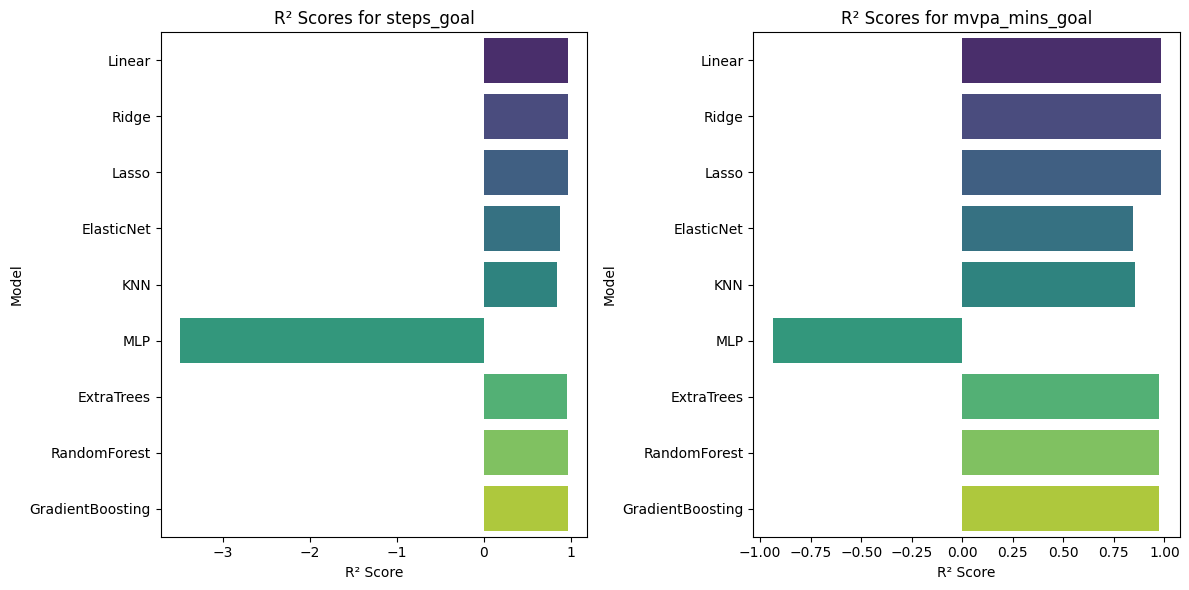

2025-06-06 15:11:03,687 - INFO - R² comparison plots saved as '../data/r2_comparison.png'


In [107]:
plt.figure(figsize=(12, 6))

# Bar plot for R² of steps_goal
plt.subplot(1, 2, 1)
model_names = list(results.keys())
r2_steps = [results[name]['R2_steps_goal'] for name in model_names]
sns.barplot(x=r2_steps, y=model_names, palette='viridis')
plt.title('R² Scores for steps_goal')
plt.xlabel('R² Score')
plt.ylabel('Model')

# Bar plot for R² of mvpa_mins_goal
plt.subplot(1, 2, 2)
r2_mvpa = [results[name]['R2_mvpa_mins_goal'] for name in model_names]
sns.barplot(x=r2_mvpa, y=model_names, palette='viridis')
plt.title('R² Scores for mvpa_mins_goal')
plt.xlabel('R² Score')
plt.ylabel('Model')

plt.tight_layout()
plt.savefig('../data/r2_comparison.png')
plt.show()
logger.info("R² comparison plots saved as '../data/r2_comparison.png'")